# Analyse des comportements de joueurs sur Steam (Jeux vid√©o)

## Nettoyage des donn√©es

In [72]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from wordcloud import WordCloud
import networkx as nx
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler
import matplotlib.cm as cm

import matplotlib
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.metrics import ConfusionMatrixDisplay
from matplotlib.colors import LinearSegmentedColormap
from sklearn.metrics import precision_recall_curve, f1_score

from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt

from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.model_selection import cross_val_score



steam_description

In [73]:
steam_description = pd.read_csv("data/steam_description_data.csv")
steam_description.info()
print(steam_description.isnull().sum())
steam_description.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 27334 entries, 0 to 27333
Data columns (total 4 columns):
 #   Column                Non-Null Count  Dtype 
---  ------                --------------  ----- 
 0   steam_appid           27334 non-null  int64 
 1   detailed_description  27334 non-null  object
 2   about_the_game        27334 non-null  object
 3   short_description     27334 non-null  object
dtypes: int64(1), object(3)
memory usage: 854.3+ KB
steam_appid             0
detailed_description    0
about_the_game          0
short_description       0
dtype: int64


steam_appid                               detailed_description  \
0           10  Play the world's number 1 online action game. ...   
1           20  One of the most popular online action games of...   
2           30  Enlist in an intense brand of Axis vs. Allied ...   
3           40  Enjoy fast-paced multiplayer gaming with Death...   
4           50  Return to the Black Mesa Research Facility as ...   

                                      about_the_game  \
0  Play the world's number 1 online action game. ...   
1  One of the most popular online action games of...   
2  Enlist in an intense brand of Axis vs. Allied ...   
3  Enjoy fast-paced multiplayer gaming with Death...   
4  Return to the Black Mesa Research Facility as ...   

                                   short_description  
0  Play the world's number 1 online action game. ...  
1  One of the most popular online action games of...  
2  Enlist in an intense brand of Axis vs. Allied ...  
3  Enjoy fast-paced multiplayer gaming with Death...  
4  Return to the Black Mesa Research Facility as ...

steam

In [74]:
steam = pd.read_csv("data/steam.csv")
steam.info()
print(steam.isnull().sum())
steam.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 27075 entries, 0 to 27074
Data columns (total 18 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   appid             27075 non-null  int64  
 1   name              27075 non-null  object 
 2   release_date      27075 non-null  object 
 3   english           27075 non-null  int64  
 4   developer         27074 non-null  object 
 5   publisher         27061 non-null  object 
 6   platforms         27075 non-null  object 
 7   required_age      27075 non-null  int64  
 8   categories        27075 non-null  object 
 9   genres            27075 non-null  object 
 10  steamspy_tags     27075 non-null  object 
 11  achievements      27075 non-null  int64  
 12  positive_ratings  27075 non-null  int64  
 13  negative_ratings  27075 non-null  int64  
 14  average_playtime  27075 non-null  int64  
 15  median_playtime   27075 non-null  int64  
 16  owners            27075 non-null  object

appid                       name release_date  english         developer  \
0     10             Counter-Strike   2000-11-01        1             Valve   
1     20      Team Fortress Classic   1999-04-01        1             Valve   
2     30              Day of Defeat   2003-05-01        1             Valve   
3     40         Deathmatch Classic   2001-06-01        1             Valve   
4     50  Half-Life: Opposing Force   1999-11-01        1  Gearbox Software   

  publisher          platforms  required_age  \
0     Valve  windows;mac;linux             0   
1     Valve  windows;mac;linux             0   
2     Valve  windows;mac;linux             0   
3     Valve  windows;mac;linux             0   
4     Valve  windows;mac;linux             0   

                                          categories  genres  \
0  Multi-player;Online Multi-Player;Local Multi-P...  Action   
1  Multi-player;Online Multi-Player;Local Multi-P...  Action   
2              Multi-player;Valve Anti-Cheat enabled  Action   
3  Multi-player;Online Multi-Player;Local Multi-P...  Action   
4  Single-player;Multi-player;Valve Anti-Cheat en...  Action   

                  steamspy_tags  achievements  positive_ratings  \
0        Action;FPS;Multiplayer             0            124534   
1        Action;FPS;Multiplayer             0              3318   
2  FPS;World War II;Multiplayer             0              3416   
3        Action;FPS;Multiplayer             0              1273   
4             FPS;Action;Sci-fi             0              5250   

   negative_ratings  average_playtime  median_playtime             owners  \
0              3339             17612              317  10000000-20000000   
1               633               277               62   5000000-10000000   
2               398               187               34   5000000-10000000   
3               267               258              184   5000000-10000000   
4               288               624              415   5000000-10000000   

   price  
0   7.19  
1   3.99  
2   3.99  
3   3.99  
4   3.99

- appid - Steam Application ID.
- name - game's name
- developer - list of the developers of the game
- publisher - list of the publishers of the game
- score_rank - score rank of the game based on user reviews
- owners - owners of this application on Steam as a range.
- average_forever - average playtime since March 2009. In minutes.
- average_2weeks - average playtime in the last two weeks. In minutes.
- median_forever - median playtime since March 2009. In minutes.
- median_2weeks - median playtime in the last two weeks. In minutes.
- ccu - peak CCU yesterday.
- price - current US price in cents.
- discount - current discount in percents.
- tags - game's tags with votes in JSON array.
- languages - list of supported languages.
- genre - list of genres.

In [75]:
# 1. Nettoyer les valeurs manquantes
steam['developer'].fillna('Unknown', inplace=True)
steam['publisher'].fillna('Unknown', inplace=True)

# 2. Convertir la date
steam['release_date'] = pd.to_datetime(steam['release_date'], errors='coerce')

# 3. S√©parer les champs multi-valeurs
steam['platforms'] = steam['platforms'].str.split(';')
steam['genres'] = steam['genres'].str.split(';')
steam['categories'] = steam['categories'].str.split(';')
steam['steamspy_tags'] = steam['steamspy_tags'].str.split(';')
steam['developer_list'] = steam['developer'].str.split(';')

# 4. Transformer les owners
steam[['owners_min', 'owners_max']] = steam['owners'].str.replace(',', '').str.split('-', expand=True).astype(int)

# 5. Convertir les bool√©ens
steam['english'] = steam['english'].astype(bool)
steam.head()

# ---------- Rennomage de colonne ----------
steam = steam.rename(columns={'appid': 'steam_appid'})

C:\Users\Corentin\AppData\Local\Temp\ipykernel_9380\2242778551.py:2: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  steam['developer'].fillna('Unknown', inplace=True)
C:\Users\Corentin\AppData\Local\Temp\ipykernel_9380\2242778551.py:3: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

F

tags

In [76]:
tags = pd.read_csv("data/steamspy_tag_data.csv")
tags.info()
print(tags.isnull().sum())
tags.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 29022 entries, 0 to 29021
Columns: 372 entries, appid to e_sports
dtypes: int64(372)
memory usage: 82.4 MB
appid           0
1980s           0
1990s           0
2.5d            0
2d              0
               ..
world_war_i     0
world_war_ii    0
wrestling       0
zombies         0
e_sports        0
Length: 372, dtype: int64


appid  1980s  1990s  2.5d  2d  2d_fighter  360_video  3d  3d_platformer  \
0     10    144    564     0   0           0          0   0              0   
1     20      0     71     0   0           0          0   0              0   
2     30      0      0     0   0           0          0   0              0   
3     40      0      0     0   0           0          0   0              0   
4     50      0     77     0   0           0          0   0              0   

   3d_vision  ...  warhammer_40k  web_publishing  werewolves  western  \
0          0  ...              0               0           0        0   
1          0  ...              0               0           0        0   
2          0  ...              0               0           0        0   
3          0  ...              0               0           0        0   
4          0  ...              0               0           0        0   

   word_game  world_war_i  world_war_ii  wrestling  zombies  e_sports  
0          0            0             0          0        0       550  
1          0            0             0          0        0         0  
2          0            5           122          0        0         0  
3          0            0             0          0        0         0  
4          0            0             0          0        0         0  

[5 rows x 372 columns]

In [77]:
#V√©rification colonne toujours √† 0 :
low_variance = tags.loc[:, tags.nunique() <= 1]
print("Colonnes constantes :", low_variance.columns.tolist())

# ---------- Rennomage de colonne ----------
tags = tags.rename(columns={'appid': 'steam_appid'})

Colonnes constantes : []


Pas de nettoyage n√©cessaire

**Jointure de toutes les donn√©es**

In [78]:
df_merged = steam.copy()
df_merged = pd.merge(df_merged, steam_description, on='steam_appid', how='left')
df_merged = pd.merge(df_merged, tags, on='steam_appid', how='left')
df_merged.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 27075 entries, 0 to 27074
Columns: 395 entries, steam_appid to e_sports
dtypes: bool(1), datetime64[ns](1), float64(1), int32(2), int64(378), object(12)
memory usage: 81.2+ MB


## Analyse exploratoire

In [79]:
df_merged.shape
df_merged.info()
df_merged.isnull().mean().sort_values(ascending=False) # pour rep√©rer les colonnes les + incompl√®tes


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 27075 entries, 0 to 27074
Columns: 395 entries, steam_appid to e_sports
dtypes: bool(1), datetime64[ns](1), float64(1), int32(2), int64(378), object(12)
memory usage: 81.2+ MB


steam_appid          0.0
quick_time_events    0.0
pve                  0.0
puzzle_platformer    0.0
puzzle               0.0
                    ... 
economy              0.0
early_access         0.0
dystopian_           0.0
dynamic_narration    0.0
e_sports             0.0
Length: 395, dtype: float64

In [80]:
df = df_merged.copy()

# Aper√ßu
df.shape
df.head()
df.info()
df.isnull().mean().sort_values(ascending=False).head(20)


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 27075 entries, 0 to 27074
Columns: 395 entries, steam_appid to e_sports
dtypes: bool(1), datetime64[ns](1), float64(1), int32(2), int64(378), object(12)
memory usage: 81.2+ MB


steam_appid              0.0
quick_time_events        0.0
pve                      0.0
puzzle_platformer        0.0
puzzle                   0.0
psychological_horror     0.0
psychological            0.0
psychedelic              0.0
programming              0.0
procedural_generation    0.0
post_apocalyptic         0.0
pool                     0.0
politics                 0.0
political                0.0
point_&_click            0.0
platformer               0.0
pixel_graphics           0.0
pirates                  0.0
pinball                  0.0
physics                  0.0
dtype: float64

Second nettoyage et cr√©ation de nouvelles colones utiles :

In [81]:
# Suppression des colonnes peu utiles
cols_to_drop = ['support_url', 'support_email', 'website', 'movies']
df.drop(columns=cols_to_drop, inplace=True, errors='ignore')

# Conversion de la date de sortie
df['release_year'] = df['release_date'].dt.year

# Cr√©ation de features utiles
df['total_ratings'] = df['positive_ratings'] + df['negative_ratings']
df['rating_ratio'] = df['positive_ratings'] / df['total_ratings'].replace(0, np.nan)
df['desc_length'] = df['short_description'].str.len()
df['popular'] = (df['owners_max'] > 50000).astype(int)
df['price_range'] = pd.cut(df['price'], bins=[-0.01, 0, 5, 20, 60, 200, df['price'].max()], labels=['Free', '<5‚Ç¨', '5-20‚Ç¨', '20-60‚Ç¨', '60-200‚Ç¨', "<"+str(df['price'].max())+"‚Ç¨"])


### Analyse univari√©e

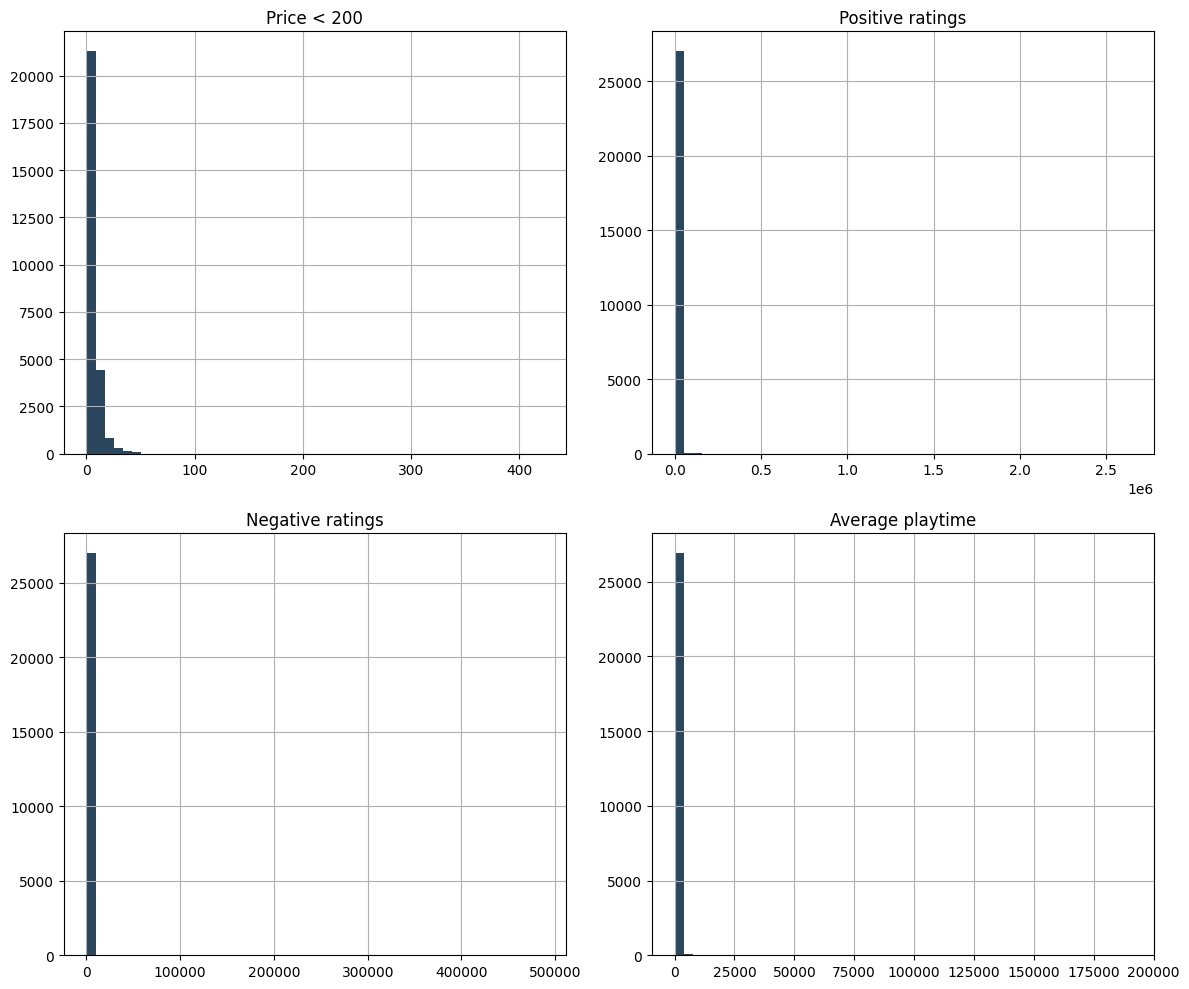

Text(0.5, 1.0, 'Nombre de jeux par ann√©e de sortie')

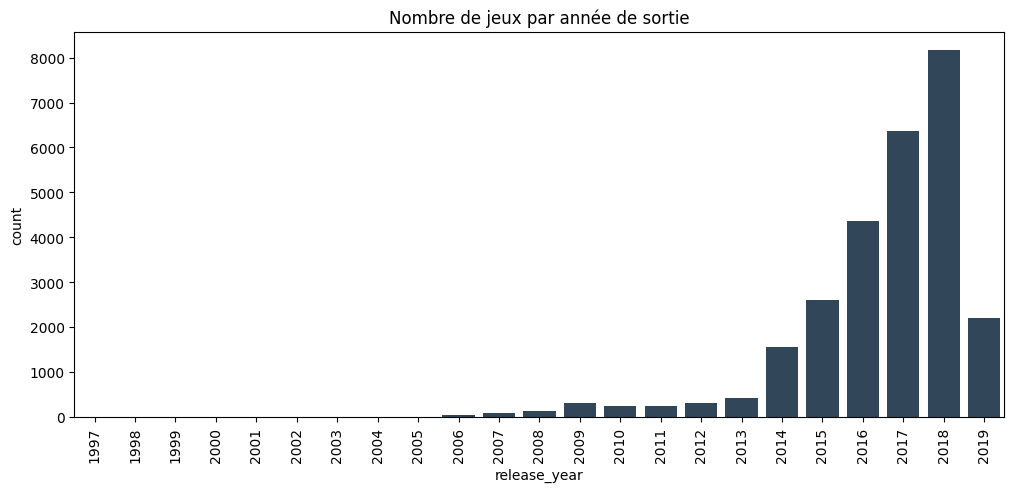

In [82]:
# Histogrammes
fig, axes = plt.subplots(2, 2, figsize=(12, 10))

# Histogramme price < 200
df['price'].hist(bins=50, ax=axes[0,0], color='#2a475e')
axes[0,0].set_title('Price < 200')

# Histograms pour les autres colonnes
df['positive_ratings'].hist(bins=50, ax=axes[0,1], color='#2a475e')
axes[0,1].set_title('Positive ratings')

df['negative_ratings'].hist(bins=50, ax=axes[1,0], color='#2a475e')
axes[1,0].set_title('Negative ratings')

df['average_playtime'].hist(bins=50, ax=axes[1,1], color='#2a475e')
axes[1,1].set_title('Average playtime')

plt.tight_layout()
plt.show()

# Distribution des ann√©es de sortie
plt.figure(figsize=(12, 5))
sns.countplot(data=df, x='release_year', color='#2a475e')
plt.xticks(rotation=90)
plt.title('Nombre de jeux par ann√©e de sortie')


On observe que pour le prix, le temps de jeu moyen et les √©valuations, la grande majorit√© des jeux pr√©sentent des valeurs tr√®s faibles, tandis qu'une minorit√© ‚Äî parfois seulement quelques titres ‚Äî affichent des valeurs nettement plus √©lev√©es. Cette distribution fortement asym√©trique m√©rite une exploration plus approfondie. Malgr√© cela, une tendance g√©n√©rale semble se dessiner en ce qui concerne les prix.

Concernant le nombre de jeux sortis par ann√©e, on observe une tendance globale √† la hausse, avec une nette acc√©l√©ration √† partir de 2014. La baisse apparente en 2019 peut s'expliquer par le fait que les donn√©es s‚Äôarr√™tent en cours d‚Äôann√©e.

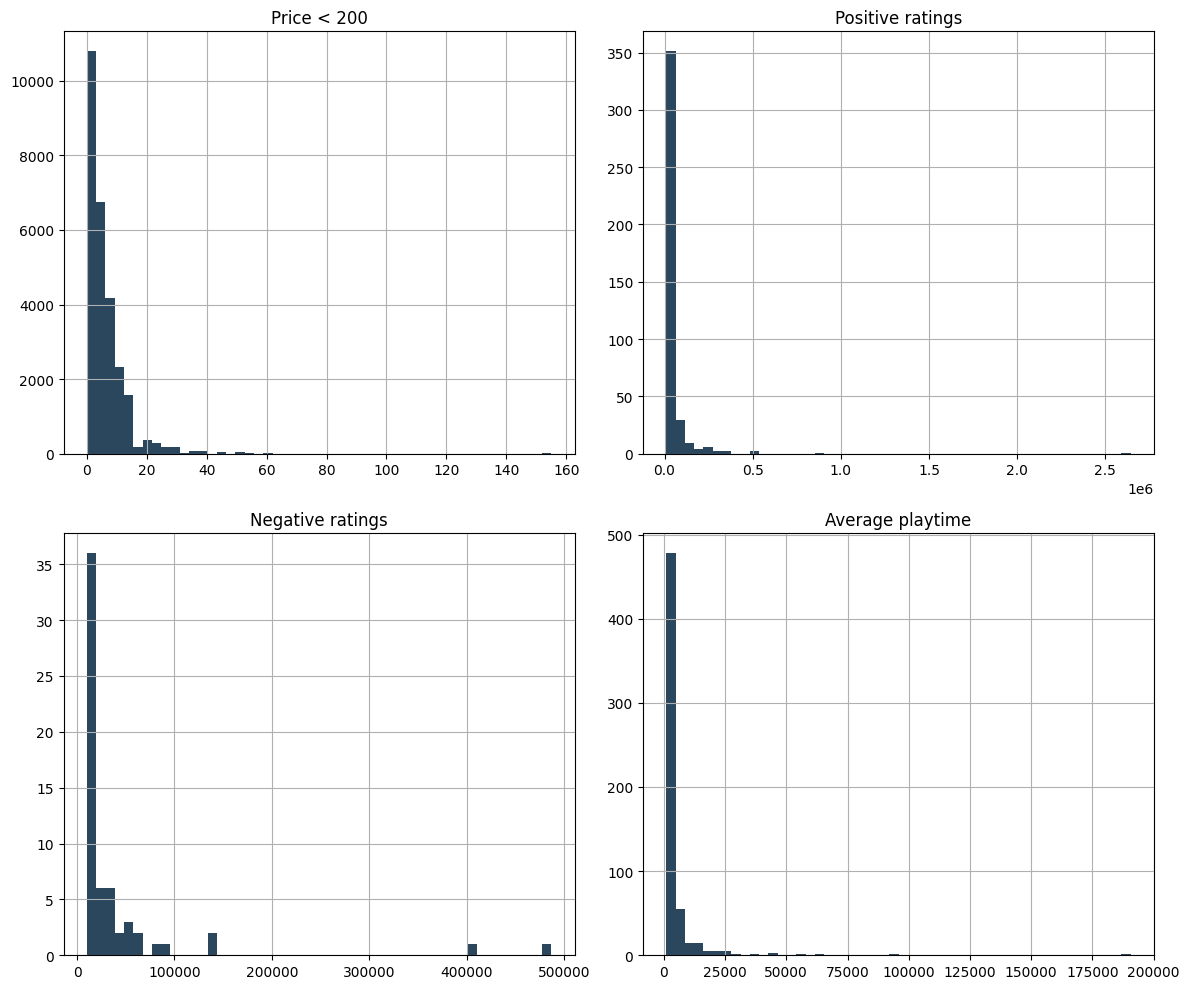

In [83]:
fig, axes = plt.subplots(2, 2, figsize=(12, 10))

# Histogramme des prix < 200
df.loc[df['price'] < 200, 'price'].hist(bins=50, ax=axes[0, 0], color='#2a475e')
axes[0, 0].set_title('Price < 200')

# Histogramme des √©valuations positives > 10
df.loc[df['positive_ratings'] > 10000, 'positive_ratings'].hist(bins=50, ax=axes[0, 1], color='#2a475e')
axes[0, 1].set_title('Positive ratings')

# Histogramme des √©valuations n√©gatives > 10
df.loc[df['negative_ratings'] > 10000, 'negative_ratings'].hist(bins=50, ax=axes[1, 0], color='#2a475e')
axes[1, 0].set_title('Negative ratings')

# Histogramme du temps de jeu moyen
df.loc[df['average_playtime'] > 1000, 'average_playtime'].hist(bins=50, ax=axes[1, 1], color='#2a475e')
axes[1, 1].set_title('Average playtime')

plt.tight_layout()
plt.show()


En fixant des seuils arbitraires et en ne regardant que les jeux √† la fois chers, populaires et bien not√©s, on observe ‚Äî comme on pouvait s'y attendre ‚Äî que la majorit√© des jeux pr√©sentent des valeurs faibles sur ces crit√®res, et que leur nombre d√©cro√Æt √† mesure que ces valeurs augmentent.

### Analyse bivari√©e

<Axes: >

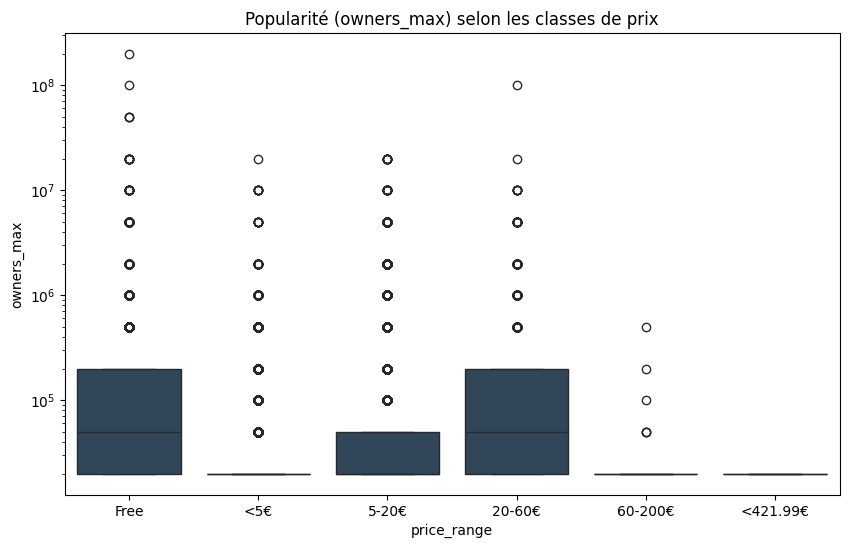

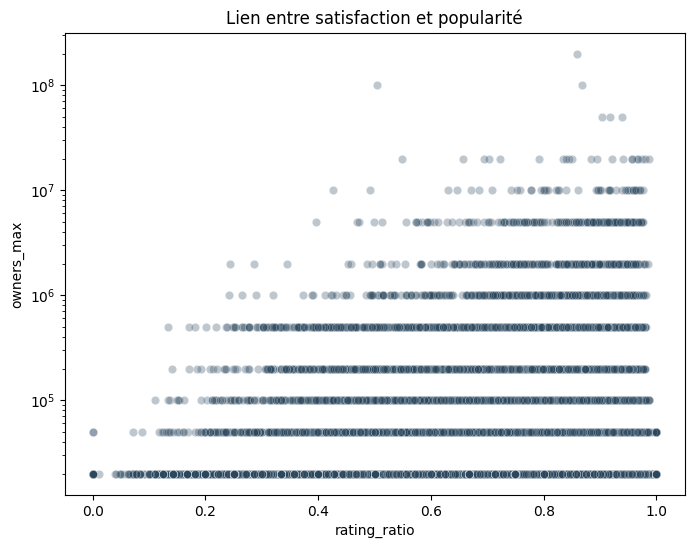

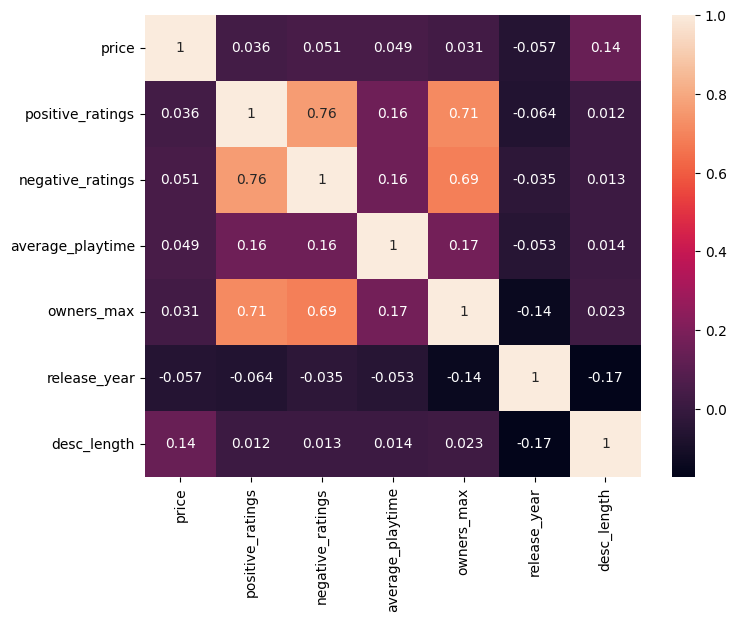

In [84]:
# Boxplot : prix vs popularit√©
plt.figure(figsize=(10,6))
sns.boxplot(data=df, x='price_range', y='owners_max', color='#2a475e')
plt.yscale('log')
plt.title("Popularit√© (owners_max) selon les classes de prix")

# Scatter : satisfaction vs popularit√©
plt.figure(figsize=(8,6))
sns.scatterplot(data=df, x='rating_ratio', y='owners_max', alpha=0.3, color='#2a475e')
plt.yscale('log')
plt.title("Lien entre satisfaction et popularit√©")

# Corr√©lations
plt.figure(figsize=(8,6))
sns.heatmap(df[['price', 'positive_ratings', 'negative_ratings', 'average_playtime', 'owners_max', 'release_year', 'desc_length']].corr(), annot=True)

#### Boxplots : Prix vs Popularit√©

En analysant la popularit√© en fonction des classes de prix, plusieurs ph√©nom√®nes int√©ressants √©mergent :

- **Deux classes se d√©marquent positivement** :
    - Les jeux gratuits, accessibles √† tous, favorisent un large nombre de t√©l√©chargements.
    - Les jeux situ√©s entre 20‚ÄØ‚Ç¨ et 60‚ÄØ‚Ç¨, qui correspondent souvent √† des blockbusters b√©n√©ficiant d'une grande visibilit√©.

- **Jeux tr√®s peu chers** :
    - M√™me s‚Äôils ne sont pas gratuits, les jeux √† prix tr√®s bas restent assez populaires gr√¢ce √† leur accessibilit√© financi√®re.
    - On retrouve ici beaucoup de jeux ind√©pendants ou casuals.

- **Jeux tr√®s chers** :
    - Leur popularit√© est en moyenne plus faible.
    - Cela peut s‚Äôexpliquer par une offre plus restreinte dans ces gammes de prix, mais aussi par un positionnement de niche, visant des joueurs tr√®s sp√©cifiques (simulateurs, jeux sp√©cialis√©s, etc.).

---

#### Analyse du scatterplot : Satisfaction vs Popularit√©

- **Jeux peu populaires** :
    - Tr√®s grande dispersion des ratios de satisfaction.
    - Cela montre que certains jeux confidentiels sont tr√®s bien not√©s, d'autres tr√®s mal ‚Äî la qualit√© ne d√©pend pas n√©cessairement de la popularit√©.

- **Tendance g√©n√©rale** :
    - Plus un jeu est populaire, meilleur est son **ratio de satisfaction**.
    - La variance diminue : les jeux populaires tendent √† recevoir des retours plus positifs de mani√®re globale.

- **Cas particulier** :
    - Une **l√©g√®re baisse du ratio de satisfaction** est visible pour les trois jeux les plus populaires.
    - Cela peut s‚Äôexpliquer par une tr√®s large audience (et donc plus de critiques diverses), ou des effets de hype/d√©ception.

---

#### Analyse des corr√©lations

##### Prix
- **Corr√©lations tr√®s faibles** (proches de 0) avec presque toutes les variables.
- Seule exception : une **l√©g√®re corr√©lation positive avec la longueur de la description** (~0.14).
    - Hypoth√®se : les jeux plus chers prennent plus de temps √† se pr√©senter, avec des descriptions plus d√©taill√©es.

##### Notes positives et n√©gatives
- **Forte corr√©lation entre `positive_ratings` et `negative_ratings`** (0.76).
    - Plus un jeu a de visibilit√©, plus il r√©colte d‚Äôavis dans les deux sens.

- **Forte corr√©lation entre `positive_ratings` et `owners_max`** (0.71), et aussi avec `negative_ratings` (~0.69).
    - Popularit√© entra√Æne davantage d‚Äôengagement (avis positifs et n√©gatifs).

##### Temps de jeu moyen
- **Corr√©lations faibles √† mod√©r√©es** (~0.15‚Äì0.17) avec :
    - Le nombre de joueurs (`owners_max`)
    - Le nombre d‚Äôavis
- Cela sugg√®re qu‚Äôun temps de jeu moyen plus long est **l√©g√®rement** associ√© √† une plus grande popularit√©.

##### Popularit√© (`owners_max`)
- Corr√©l√©e aux :
    - `positive_ratings` (0.71)
    - `negative_ratings` (0.69)
- **Corr√©lation n√©gative mod√©r√©e avec `release_year`** (-0.14) :
    - Les jeux plus anciens tendent √† √™tre plus populaires, ayant eu plus de temps pour se diffuser.

##### Ann√©e de sortie
- **Corr√©lations n√©gatives faibles** avec la plupart des variables :
    - Les jeux r√©cents ont **moins de joueurs, moins d‚Äôavis, des descriptions plus courtes et des temps de jeu moyens plus faibles**.

##### Longueur de la description
- Corr√©lations tr√®s faibles avec toutes les autres variables.

---

#### Synth√®se g√©n√©rale

- **La popularit√© (`owners_max`)** est fortement li√©e :
    - √Ä la **quantit√© d‚Äôavis** (positifs et n√©gatifs).
    - √Ä l‚Äô**anciennet√© du jeu**.

- **Le prix** n‚Äôest **quasiment pas corr√©l√©** √† la popularit√©, aux notes, ou au temps de jeu.

- **Les jeux r√©cents** tendent √† √™tre :
    - Moins populaires.
    - Moins comment√©s.
    - Moins d√©taill√©s dans leurs fiches.

- **Le temps de jeu moyen** a un **impact tr√®s limit√©** sur les autres variables, mais reste **l√©g√®rement positif** en lien avec la popularit√©.

---


### Analyse des tags

<Axes: title={'center': 'Tags associ√©s √† des jeux populaires'}>

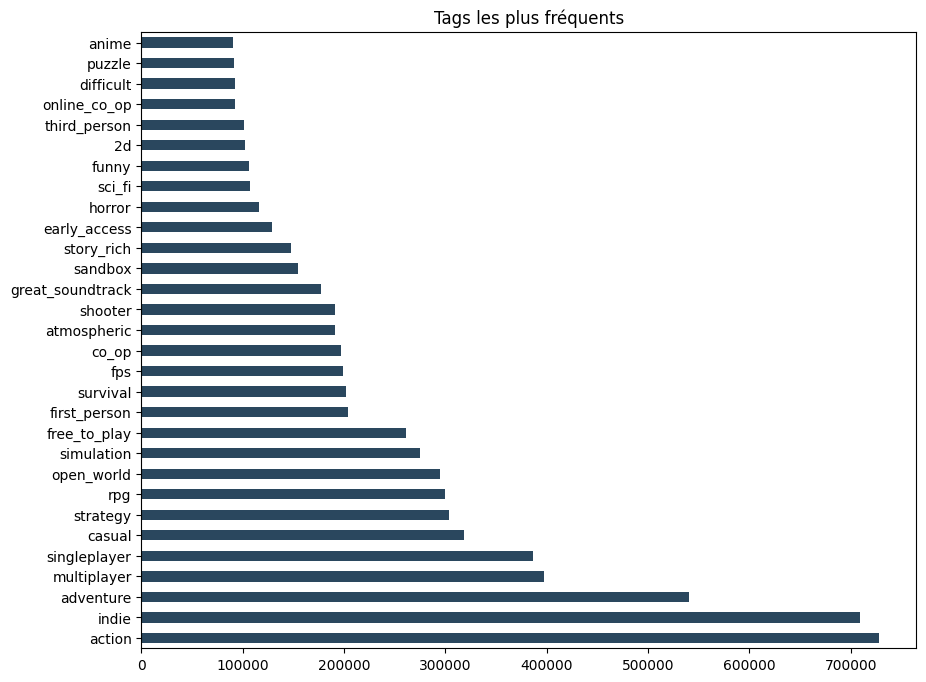

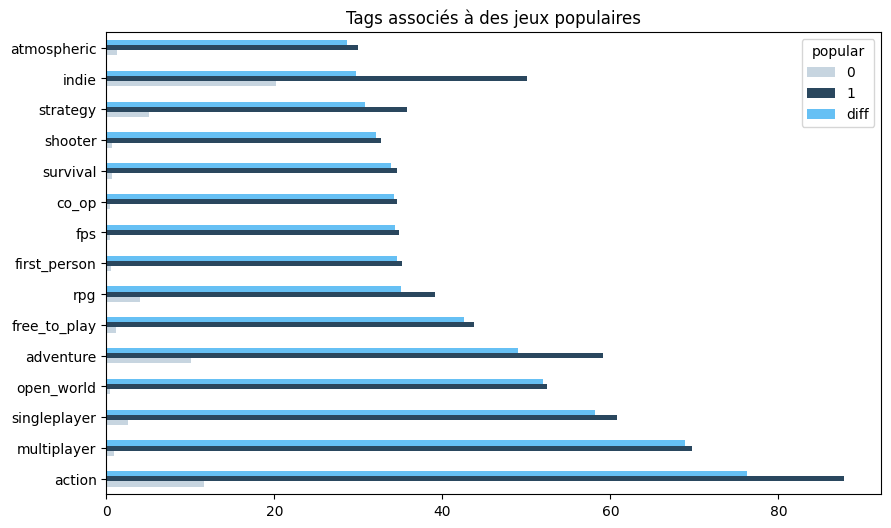

In [85]:
# Extraction des colonnes tags
tag_cols =  df.columns[24:394]

# Top tags utilis√©s
tag_sums = df[tag_cols].sum().sort_values(ascending=False).head(30)
tag_sums.plot(kind='barh', figsize=(10,8), title="Tags les plus fr√©quents", color='#2a475e')

# Tags favorables √† la popularit√©
tag_success = df.groupby('popular')[tag_cols].mean().T
tag_success['diff'] = tag_success[1] - tag_success[0]
tag_success.sort_values('diff', ascending=False).head(15).plot(
    kind='barh',
    figsize=(10, 6),
    title="Tags associ√©s √† des jeux populaires",
    color=['#c7d5e0', '#2a475e', '#66c0f4']  # bleu (hex), tu peux mettre une couleur diff√©rente
)




- Le tag action est le plus r√©pandu (728 416 jeux) : cela signifie que parmi tous les jeux du dataset, environ 728 416 sont identifi√©s comme jeux d‚Äôaction, ce qui en fait la cat√©gorie la plus repr√©sent√©e.
- Les tags indie (709 652), adventure (540 123) et multiplayer (397 327) suivent de pr√®s. Cela indique que les jeux ind√©pendants et d‚Äôaventure sont tr√®s nombreux, et que les jeux multijoueurs occupent √©galement une place importante.
- Des tags comme singleplayer (386 511), casual (318 387) ou strategy (303 942) repr√©sentent d‚Äôautres grandes cat√©gories tr√®s pr√©sentes dans le dataset.
- On note aussi la pr√©sence de tags plus sp√©cifiques ou qualitatifs, tels que great_soundtrack (177 153) ou atmospheric (190 813), qui refl√®tent davantage des crit√®res d‚Äôappr√©ciation ou d‚Äôambiance que des genres stricts.

Cependant il reste des points d‚Äôattention :

- Redondances et chevauchements : certains tags peuvent se recouper, par exemple shooter et fps, ou multiplayer et co_op, ce qui peut introduire des doublons dans l‚Äôanalyse.
- D√©s√©quilibre des tags : certains tags tr√®s fr√©quents peuvent masquer la pr√©sence de cat√©gories plus sp√©cifiques ou de niche.

Tags les plus associ√©s √† la popularit√© :

- action, multiplayer, singleplayer, open_world, adventure sont en t√™te : ce sont clairement des caract√©ristiques cl√©s des jeux populaires.

- Par exemple, un jeu multijoueur ou avec un mode solo tr√®s marqu√© a plus de chances d‚Äô√™tre populaire.

Interpr√©tation g√©n√©rale :

- Les tags li√©s √† l‚Äôaction et √† l‚Äôexp√©rience de jeu immersive (open_world, fps, shooter) ont un impact fort.

- Les jeux qui m√©langent des modes solo et multijoueur sont largement plus populaires.

- M√™me le tag free_to_play a une diff√©rence positive importante, ce qui montre que certains jeux gratuits sont aussi tr√®s populaires.

Limitations :

- Cette analyse montre une corr√©lation, pas une causalit√©. Le tag "action" ne cause pas la popularit√©, mais il est tr√®s fr√©quent dans les jeux populaires.

- Certains tags ont un poids √©lev√© peut-√™tre parce qu‚Äôils sont plus r√©pandus dans des genres tr√®s jou√©s.

Pour cela il est interessant de faire une matrice de co-occurence

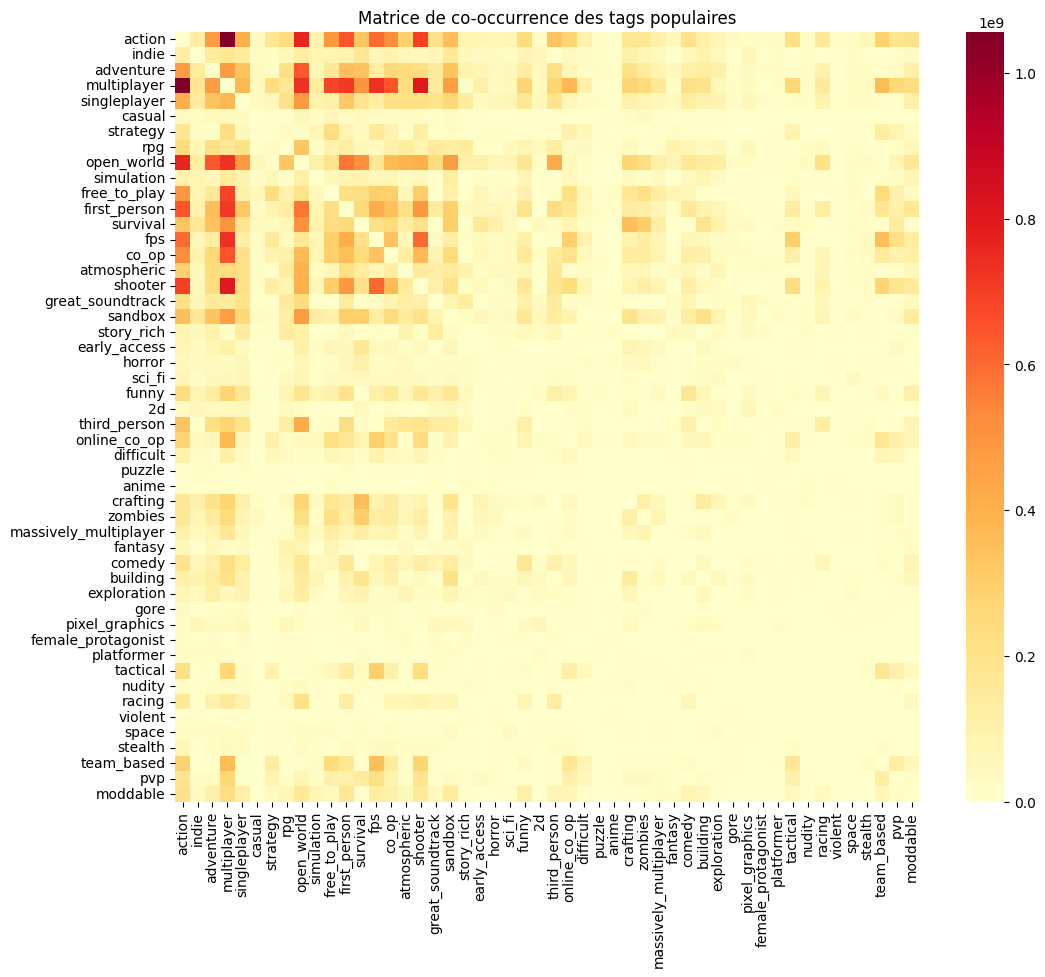

feature_film        0.0
360_video        1925.0
skating          4375.5
bmx              4882.5
hardware         7598.0
cycling         12171.0
atv             13235.0
foreign         14510.0
hockey          17406.0
tennis          24796.5
dtype: float64


In [86]:
tag_sums = df[tag_cols].sum().sort_values(ascending=False).head(50)
# Matrice de co-occurrence (multiplication de la matrice binaire des tags par sa transpos√©e)
tag_matrix = df[tag_cols].astype(int)
co_occurrence = tag_matrix.T.dot(tag_matrix)

# On supprime la diagonale pour √©viter la surrepr√©sentation
np.fill_diagonal(co_occurrence.values, 0)

# Affichage d'une heatmap des tags les plus fr√©quents
top_tags = tag_sums.head(200).index
plt.figure(figsize=(12,10))
sns.heatmap(co_occurrence.loc[top_tags, top_tags], cmap="YlOrRd")
plt.title("Matrice de co-occurrence des tags populaires")
plt.show()

somme_par_colonne = co_occurrence.sum()/2
plus_faibles = somme_par_colonne.nsmallest(10)
print(plus_faibles)

Sur cette matrice de co-occurrence, on observe que certains tags apparaissent fr√©quemment ensemble sur les m√™mes jeux, ce qui r√©v√®le des relations fortes entre ces cat√©gories. Par exemple, les tags 'multiplayer' et 'action' coexistent tr√®s souvent, ce qui est coh√©rent car de nombreux jeux d'action proposent un mode multijoueur.

De plus, ces deux tags sont aussi fr√©quemment associ√©s avec d'autres tags populaires comme 'open_world', 'free_to_play', 'fps', 'co_op' et 'shooter'. Cela indique l'existence d'un groupe de jeux tr√®s actifs et comp√©titifs, souvent en ligne, o√π ces caract√©ristiques se combinent pour d√©finir l'exp√©rience utilisateur.

En revanche, certains tags montrent peu de co-occurrences avec les autres, ce qui peut sugg√©rer qu'ils correspondent √† des niches sp√©cifiques ou √† des caract√©ristiques plus isol√©es. Par exemple, 'skating', 'bmx' ou 'hardware' apparaissent rarement associ√©s avec d'autres tags. Cela peut refl√©ter un public cibl√© plus restreint ou des jeux tr√®s sp√©cialis√©s.

Enfin, certains tags comme 'feature_film' n'ont aucune co-occurrence, ce qui est logique car ce tag pourrait ne pas √™tre utilis√© conjointement avec d'autres dans ce dataset, ou repr√©senter une cat√©gorie totalement distincte.

Cette analyse montre ainsi comment la matrice de co-occurrence permet d'identifier des clusters th√©matiques dans les jeux, en r√©v√©lant les combinaisons de tags les plus fr√©quentes, tout en mettant en lumi√®re des cat√©gories plus marginales ou uniques.


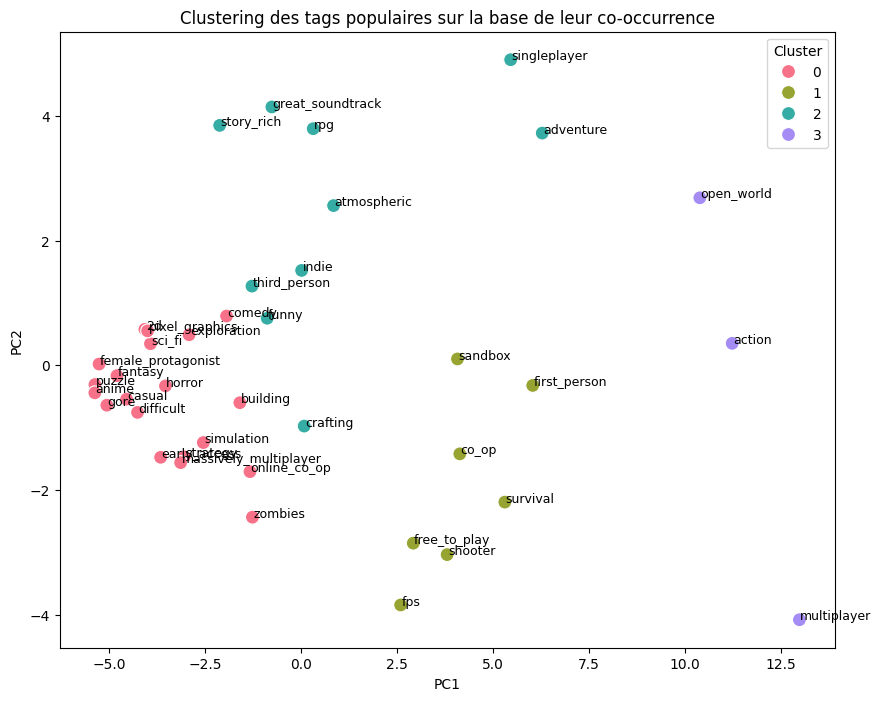

In [87]:
top_tags = tag_sums.head(40).index
co_occ_sub = co_occurrence.loc[top_tags, top_tags]

# Normaliser les donn√©es
scaler = StandardScaler()
co_occ_scaled = scaler.fit_transform(co_occ_sub)

# R√©duction de dimension √† 2 composantes principales
pca = PCA(n_components=2)
co_occ_pca = pca.fit_transform(co_occ_scaled)

# Appliquer un clustering KMeans (par exemple 4 clusters, tu peux ajuster)
k = 4
kmeans = KMeans(n_clusters=k, random_state=4)
clusters = kmeans.fit_predict(co_occ_pca)

# Visualisation
plt.figure(figsize=(10,8))
palette = sns.color_palette("husl", k)
sns.scatterplot(x=co_occ_pca[:,0], y=co_occ_pca[:,1], hue=clusters, palette=palette, s=100)

for i, tag in enumerate(top_tags):
    plt.text(co_occ_pca[i,0]+0.02, co_occ_pca[i,1], tag, fontsize=9)

plt.title("Clustering des tags populaires sur la base de leur co-occurrence")
plt.xlabel("PC1")
plt.ylabel("PC2")
plt.legend(title="Cluster")
plt.show()


Cluster 0 : Mix ‚ÄúCasual √† strat√©gique‚Äù avec ambiance et diversit√© narrative

- Beaucoup de diversit√© : strat√©gie, simulation, casual mais aussi des univers tr√®s th√©matiques (horror, sci-fi, fantasy, zombies, gore).

- M√©lange de styles 2D, pixel art, narratives (female protagonist, comedy) et challenge (difficult, puzzle).

- Jeux souvent avec modes en ligne ou coop (massively multiplayer, online_co_op).

- Beaucoup peuvent √™tre exp√©rimentaux ou en d√©veloppement (early_access).

- Ces jeux attirent probablement une communaut√© large et passionn√©e par la profondeur, l‚Äôexploration, et les exp√©riences narratives ou esth√©tiques marqu√©es.

Cluster 1 : FPS & survie multijoueur, ambiance ‚Äúcore gamer‚Äù / comp√©titive

- Regroupe surtout les jeux d‚Äôaction √† la premi√®re personne (FPS), tir et survie.

- Orientation souvent multijoueur/co-op dans un monde sandbox.

- Free-to-play indique des mod√®les √©conomiques souvent comp√©titifs et communautaires (ex : battle royale, jeux de tir populaires).

- Cluster clairement centr√© sur des joueurs qui cherchent du challenge, de l‚Äôaction rapide et de la coop√©ration tactique.

Cluster 2 : Jeux ‚ÄúIndie aventure narrative et RPG‚Äù

- Ce sont des jeux souvent solo, orient√©s aventure et RPG avec une forte ambiance.

- Mise en avant de la narration (story_rich), de l‚Äôatmosph√®re et de la musique (great_soundtrack).

- Style souvent indie, plus artistique et exp√©rimental.

- Inclut aussi du crafting, gameplay souvent profond et exploration immersive.

- Cluster typique des jeux qui misent sur l‚Äôexp√©rience √©motionnelle et la cr√©ativit√© plus que sur la comp√©tition ou l‚Äôaction pure.

Cluster 3 : Action multijoueur et open world

- Cluster plus simple, mais tr√®s coh√©rent.

- Regroupe les jeux orient√©s action avec des mondes ouverts, souvent en multijoueur.

- Ce sont probablement des jeux AAA, avec de grands mondes √† explorer, souvent tr√®s populaires.

- Le c≈ìur du gameplay est dynamique, comp√©titif ou coop√©ratif, mais avec une libert√© d‚Äôexploration importante.

### Analyse des d√©veloppeurs

Je vais commencer par analyser les d√©veloppeurs les plus actifs et leur popularit√©

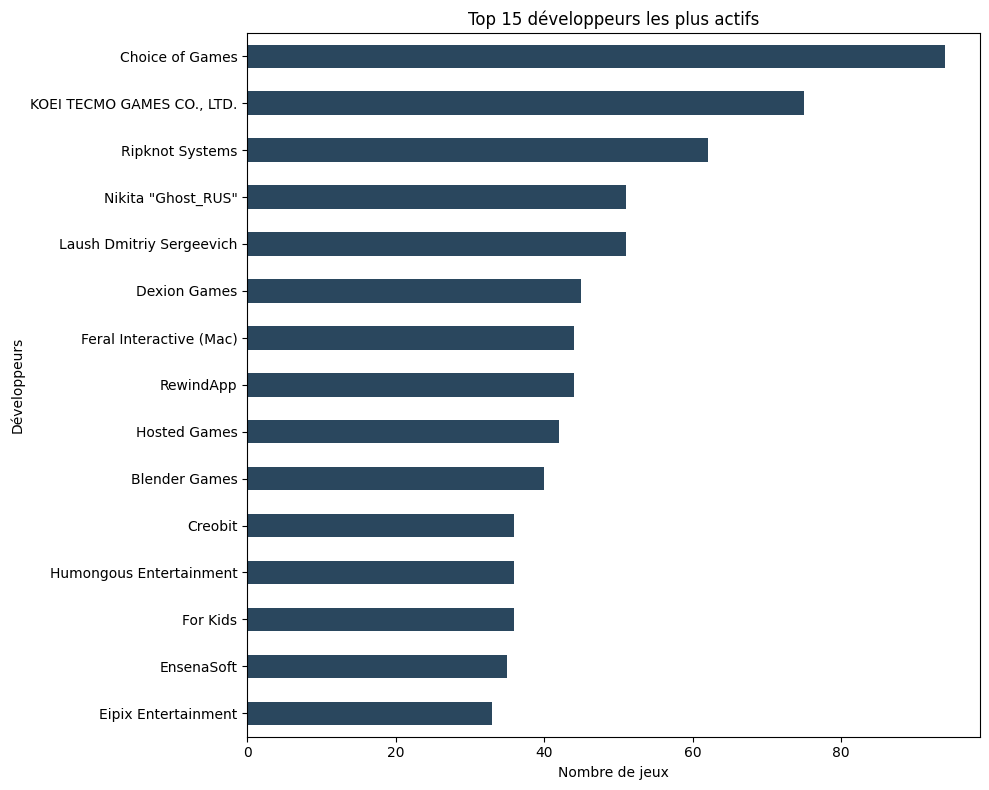

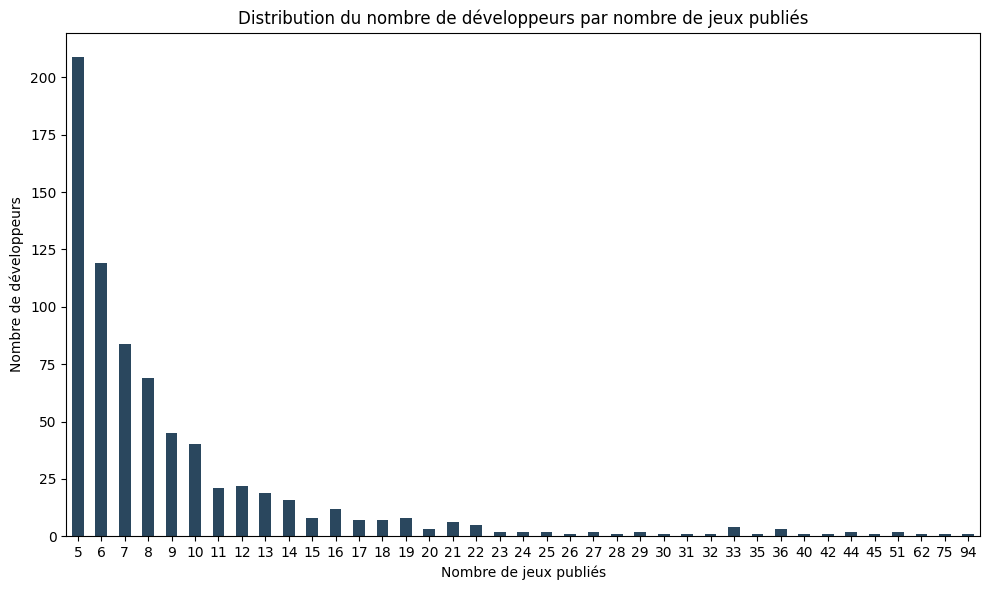

In [88]:
# 1. Explosion de la colonne liste : une ligne par d√©veloppeur
df_exploded = df.explode('developer_list')

# 2. Compte du nombre de jeux par d√©veloppeur
top_devs = df_exploded['developer_list'].value_counts()

# === Graphique 1 : Top 15 d√©veloppeurs les plus actifs ===
plt.figure(figsize=(10, 8))
top_devs.head(15).plot(kind='barh', color='#2a475e')
plt.title("Top 15 d√©veloppeurs les plus actifs")
plt.xlabel("Nombre de jeux")
plt.ylabel("D√©veloppeurs")
plt.gca().invert_yaxis()
plt.tight_layout()
plt.show()

# === Graphique 2 : Distribution nombre de jeux / nombre de d√©veloppeurs ===
games_per_dev = df_exploded['developer_list'].value_counts()

# Compte combien de d√©veloppeurs ont publi√© n jeux
dev_count_by_game_number = games_per_dev.value_counts().sort_index()
dev_count_by_game_number = dev_count_by_game_number[dev_count_by_game_number.index >= 5]

plt.figure(figsize=(10, 6))
dev_count_by_game_number.plot(kind='bar', color='#2a475e')
plt.title("Distribution du nombre de d√©veloppeurs par nombre de jeux publi√©s")
plt.xlabel("Nombre de jeux publi√©s")
plt.ylabel("Nombre de d√©veloppeurs")
plt.xticks(rotation=0)
plt.tight_layout()
plt.show()


On observe qu‚Äôun nombre restreint de d√©veloppeurs se d√©marque nettement en ayant publi√© plus de 40 jeux. Une seconde cat√©gorie regroupe des studios actifs, comptant entre 15 et 40 titres, tandis que la grande majorit√© des d√©veloppeurs n‚Äôont publi√© que quelques jeux, souvent moins de 15.

Cette distribution sugg√®re une concentration de la production autour de quelques studios tr√®s prolifiques, alors qu‚Äôune grande partie de l‚Äôoffre sur Steam provient de petits studios ou d‚Äôind√©pendants aux catalogues plus modestes.

<Axes: title={'center': 'Studios avec jeux populaires (moyenne > 100k owners)'}, ylabel='D√©veloppeurs'>

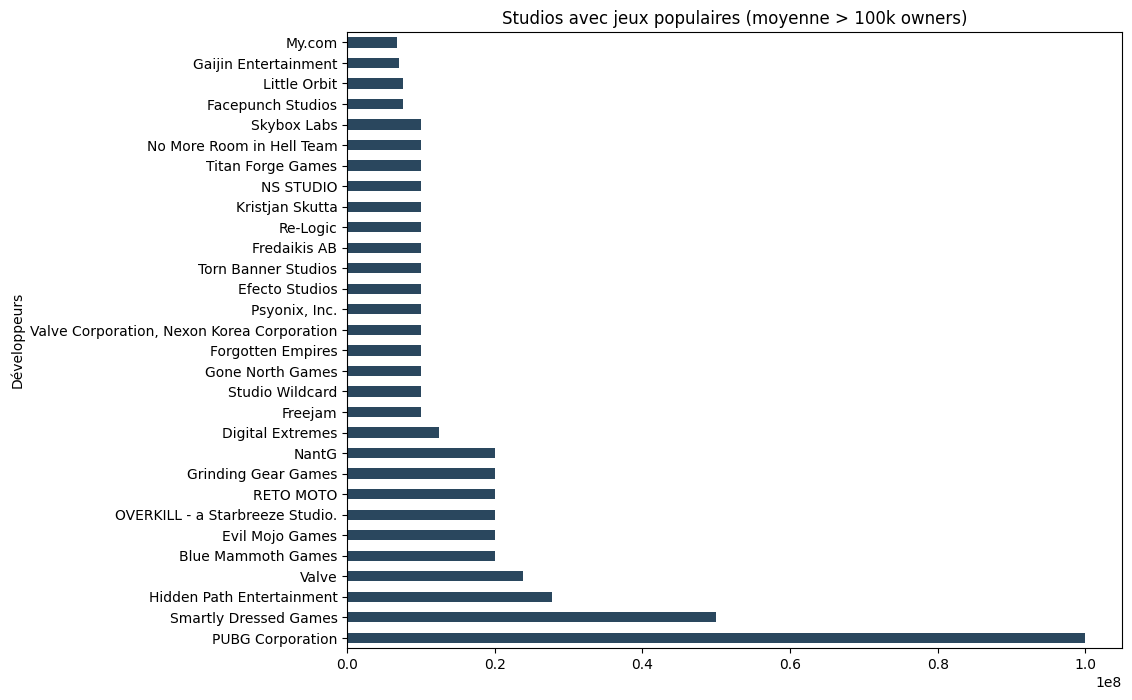

In [89]:
# Exploser pour avoir une ligne par d√©veloppeur individuel
df_exploded = df.explode('developer_list')

# Nettoyer les espaces si besoin
df_exploded['developer_list'] = df_exploded['developer_list'].str.strip()

# Calculer la moyenne d'owners_max par d√©veloppeur
popular_devs = df_exploded.groupby('developer_list')['owners_max'].mean().sort_values(ascending=False)

# 5. Visualisation
popular_devs.head(30).plot(
    kind='barh',
    figsize=(10, 8),
    title="Studios avec jeux populaires (moyenne > 100k owners)",
    color='#2a475e', 
    ylabel="D√©veloppeurs"
    )

Ce que ces chiffres montrent :

- Ce tableau classe les 30 studios de jeux vid√©o ayant les jeux les plus populaires (en moyenne), selon le nombre estim√© de joueurs poss√©dant ces jeux sur Steam (owners_max).

- PUBG Corporation est largement en t√™te, avec un jeu d√©passant les 100 millions de joueurs.

- Des noms bien connus comme Valve/Valve Corporation (cr√©ateur de Half-Life, CS:GO, Dota) apparaissent aussi en haut de classement.

- D'autres comme Psyonix (cr√©ateur de Rocket League) ou Re-Logic (Terraria) confirment leur succ√®s plan√©taire.

Ce qu'on peut en conclure simplement :

- Les studios list√©s ici ont souvent publi√© un ou deux √©normes succ√®s, plus que des dizaines de petits jeux.

- Beaucoup de ces jeux sont free-to-play ou massivement multijoueur, ce qui attire plus de joueurs.

- Certains noms sont peu connus du grand public, mais ont perc√© avec un seul hit viral (Kristjan Skutta, Gone North Games...).

Analyse technique et approfondie :

1. PUBG Corporation en t√™te : un one-hit wonder

- PUBG (PlayerUnknown‚Äôs Battlegrounds) a explos√© le march√© du Battle Royale bien avant Fortnite sur Steam.

- Le fait qu‚Äôils aient qu‚Äôun seul jeu dans ton dataset explique cette moyenne √©norme (1 jeu = 100M ‚Üí moyenne = 100M).

- Il faut donc nuancer : on mesure ici des moyennes, pas un volume total de jeux.

2. üïπ Valve : valeur s√ªre avec plusieurs hits

- Valve est ici repr√©sent√© deux fois : Valve et Valve Corporation, Nexon Korea Corporation (co-d√©veloppement de Counter-Strike Online en Asie)

- Leurs jeux (CS:GO, Dota 2, TF2) sont gratuits et tr√®s populaires, ce qui biaisent positivement la m√©trique owners_max.

- Ils sont aussi les cr√©ateur de plateforme Steam elle-m√™me, ce qui renforce leur exposition.

3. üéÆ Petits d√©veloppeurs, gros coups

- Kristjan Skutta : d√©veloppeur solo du jeu Unturned, un jeu de survie gratuit ayant explos√© gr√¢ce √† son gameplay simple et √† la communaut√© YouTube/Twitch.

- Gone North Games : d√©veloppeur de A Story About My Uncle, un jeu d‚Äôaventure narratif qui a eu un petit succ√®s critique.

- Ces exemples montrent que la viralit√© peut battre le budget : certains d√©veloppeurs inconnus d√©passent des g√©ants gr√¢ce √† la communaut√©.

Biais √† conna√Ætre dans cette m√©trique :

- En regardant une moyenne, un seul jeu ultra-populaire gonfle le r√©sultat (exemple de PUBG).

- Les studios qui font beaucoup de jeux modestes appara√Ætront moins, m√™me s‚Äôils ont de la qualit√©.

- Les donn√©es sont estimat√©es, Steam ne donne pas officiellement les chiffres du nombre de personnes poss√©dant un jeu (ici on utilise des intervalles).


Il peut donc √™tre interessant d'analyser le taux de satisfaction par d√©veloppeur :

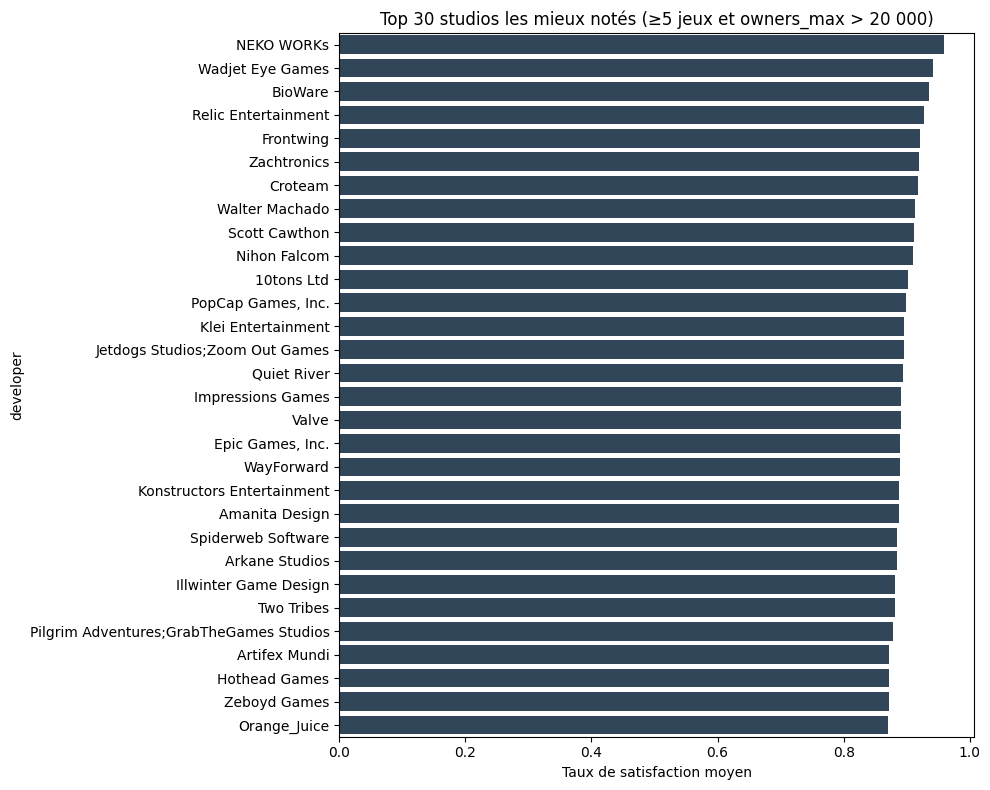

n_games  avg_rating
developer                                                   
NEKO WORKs                                     6    0.958419
Wadjet Eye Games                               7    0.940896
BioWare                                        5    0.934578
Relic Entertainment                            8    0.926919
Frontwing                                      5    0.920568
Zachtronics                                    7    0.918965
Croteam                                        5    0.917025
Walter Machado                                 6    0.912987
Scott Cawthon                                  8    0.911100
Nihon Falcom                                  11    0.910124
10tons Ltd                                     6    0.901947
PopCap Games, Inc.                            10    0.898828
Klei Entertainment                             7    0.895675
Jetdogs Studios;Zoom Out Games                 5    0.895335
Quiet River                                   15    0.893181
Impressions Games                              5    0.891496
Valve                                         26    0.890779
Epic Games, Inc.                               5    0.889402
WayForward                                     5    0.888578
Konstructors Entertainment                     5    0.888386
Amanita Design                                 5    0.887881
Spiderweb Software                            14    0.885189
Arkane Studios                                 6    0.884427
Illwinter Game Design                          5    0.880624
Two Tribes                                     5    0.880491
Pilgrim Adventures;GrabTheGames Studios        5    0.877947
Artifex Mundi                                 15    0.872052
Hothead Games                                  5    0.871303
Zeboyd Games                                   5    0.870981
Orange_Juice                                   7    0.870790

In [90]:
matplotlib.rcParams['font.family'] = 'DejaVu Sans'  # Par d√©faut, bonne couverture

# Filtrer les jeux
df_filtered = df[df['owners_max'] > 20000]

# Moyenne de rating_ratio (satisfaction) par d√©veloppeur avec au moins 5 jeux (parmi les jeux populaires)
dev_ratings = df_filtered.groupby('developer').agg(
    n_games=('steam_appid', 'count'),
    avg_rating=('rating_ratio', 'mean')
)

# üîé Garder les d√©veloppeurs avec au moins 5 jeux
dev_ratings_filtered = dev_ratings[dev_ratings['n_games'] >= 5].sort_values('avg_rating', ascending=False).head(30)

# Visualisation
plt.figure(figsize=(10, 8))
sns.barplot(data=dev_ratings_filtered, x='avg_rating', y=dev_ratings_filtered.index, color='#2a475e')
plt.xlabel("Taux de satisfaction moyen")
plt.title("Top 30 studios les mieux not√©s (‚â•5 jeux et owners_max > 20 000)")
plt.tight_layout()
plt.show()

# Affichage du DataFrame final
dev_ratings_filtered


Les r√©sultats r√©v√®lent :
1. Studios tr√®s appr√©ci√©s, m√™me s‚Äôils ne sont pas ultra-mainstream

NEKO WORKs (avg rating ‚âà 95.8 %) :

- Studio japonais connu pour la s√©rie Nekopara (visual novel tr√®s populaire).

- Petites productions, mais tr√®s bien accueillies par leur public cibl√©.

- Leur excellent score montre une niche fid√®le et satisfaite.

Wadjet Eye Games (~94 %) :

- Sp√©cialistes de point-and-click narratifs (ex : Blackwell, Unavowed).

- Tr√®s respect√©s dans le milieu ind√© : peu de jeux, mais tr√®s qualitatifs.

    Zachtronics (~91.9 %) :

- R√©put√© pour ses jeux de programmation/logique (Opus Magnum, TIS-100).

- Touche un public de joueurs "experts", tr√®s fid√®les.

Ces studios sont des exemples d‚Äôexcellence dans leur niche, avec des taux de satisfaction tr√®s √©lev√©s malgr√© des tailles modestes.

2. Studios plus classiques / AAA bien class√©s aussi

BioWare (~93.5 %) :

- Mass Effect, Dragon Age‚Ä¶ malgr√© quelques controverses r√©centes, leur "legacy" reste fort.

Relic Entertainment (~92.7 %) :

- Company of Heroes, Dawn of War ‚Üí excellents jeux de strat√©gie, communaut√© passionn√©e.

Valve (~89.1 %) :

- Avec 26 jeux pass√©s le filtre des 20 000 owners, c‚Äôest le plus prolifique du top 30.

- Malgr√© la diversit√©, la moyenne reste tr√®s √©lev√©e, preuve d‚Äôune qualit√© constante.

Arkane Studios (~88.4 %) :

- Dishonored, Prey‚Ä¶ des jeux innovants salu√©s pour leur gameplay et level design.

Leur pr√©sence valide que certaines grandes entreprises peuvent maintenir une qualit√© √©lev√©e malgr√© la pression commerciale et les volumes de production.


3. Studios ind√©pendants ou atypiques

Scott Cawthon (~91.1 %) : Cr√©ateur de Five Nights at Freddy‚Äôs ‚Üí tr√®s clivant, mais ador√© par sa communaut√©.

Amanita Design (~88.8 %) : Machinarium, Samorost‚Ä¶ direction artistique unique, excellente immersion sonore/graphique.

Spiderweb Software (~88.5 %) : Tr√®s anciens RPG old-school, tr√®s bien not√©s malgr√© des graphismes simples.

Ces studios montrent que l‚Äôoriginalit√© paie : si le jeu a une personnalit√© forte et un public clair, il peut obtenir des scores de satisfaction excellents.


Une analyse du rating_ratio moyen par d√©veloppeur, filtr√©e sur les jeux ayant au moins 20 000 utilisateurs estim√©s, r√©v√®le une surrepr√©sentation de studios ind√©pendants et sp√©cialis√©s. Leur capacit√© √† satisfaire une base d‚Äôutilisateurs cibl√©e semble les avantager par rapport √† des studios plus g√©n√©ralistes. N√©anmoins, certains g√©ants comme Valve, BioWare ou Relic maintiennent un excellent niveau de satisfaction tout en publiant de nombreux titres

Prix moyen des jeux par studio :

n_games  avg_price
developer                                       
KT Racing                           5  34.990000
FIRST_UKRAINIAN                     5  31.630000
Croteam VR                          5  30.190000
KOEI TECMO GAMES CO., LTD.         72  28.014028
Spike Chunsoft Co., Ltd.           10  27.900000
ARTDINK                             9  26.990000
Tamsoft                             6  26.823333
Codemasters                         6  26.490000
HB Studios                          5  23.290000
Ageod                               7  23.247143
Alternative Software Ltd            5  22.990000
WarfareSims                         6  22.906667
Big Ant Studios                    11  22.627273
Sports Interactive                  6  22.491667
Fury Software                       5  22.330000
Nihon Falcom                       16  22.271250
CAPCOM Co., Ltd.                   15  21.990667
KING Art                            7  21.990000
Eversim                             7  21.132857
Flying Wild Hog                     5  20.990000
Games Farm                          5  20.670000
Ubisoft                            13  20.205385
Nippon Ichi Software, Inc.         11  19.899091
Illwinter Game Design               5  19.790000
Frontier Developments               5  19.790000
Out of the Park Developments        7  19.775714
Konami Digital Entertainment        7  19.421429
Obsidian Entertainment              7  19.304286
Totem Games                        12  19.101667
Larian Studios                      6  19.090000

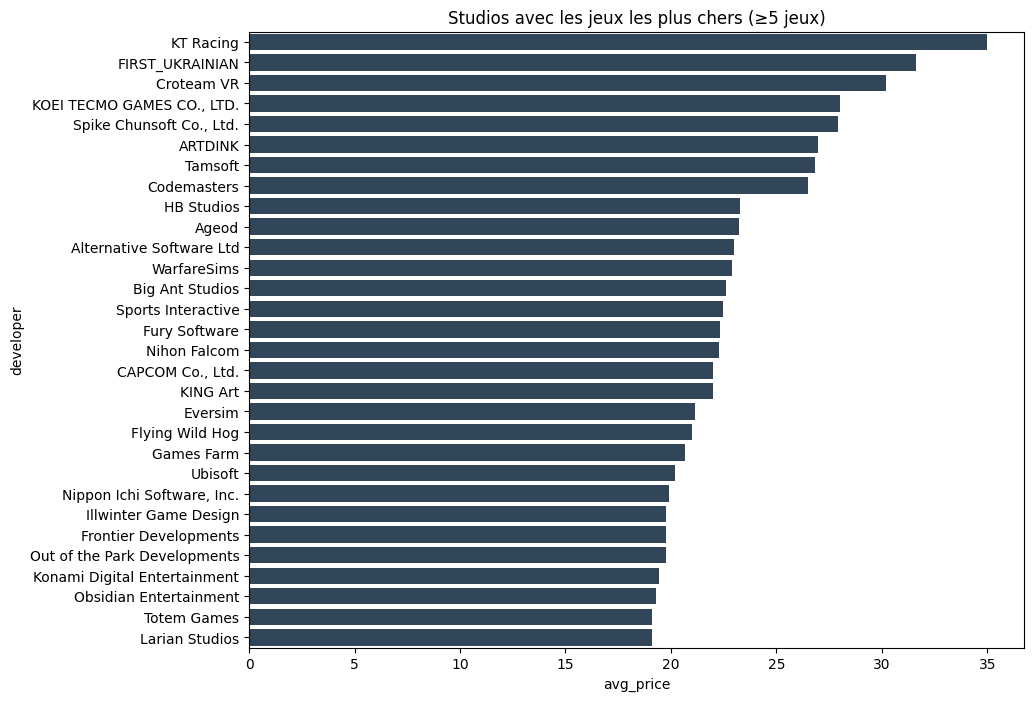

In [91]:
# Prix moyen par d√©veloppeur (filtr√©s pour au moins 5 jeux)
dev_prices = df.groupby('developer').agg(
    n_games=('steam_appid', 'count'),
    avg_price=('price', 'mean')
)
dev_prices_filtered = dev_prices[dev_prices['n_games'] >= 5].sort_values('avg_price', ascending=False).head(30)


plt.figure(figsize=(10, 8))
sns.barplot(data=dev_prices_filtered, x='avg_price', y=dev_prices_filtered.index, color='#2a475e')
plt.title("Studios avec les jeux les plus chers (‚â•5 jeux)")

dev_prices_filtered


On remarque :

- KT Racing publie les jeux les plus cher, ce qui correspond √† leur positionnement sur des jeux de course automobile r√©alistes (ex : WRC series).

- Croteam VR vend des versions VR de leurs titres, souvent √† prix fort.

- KOEI TECMO est un cas int√©ressant : avec 72 jeux, ils arrivent √† garder un prix moyen √©lev√© ‚Üí probablement d√ª √† des licences d'anime populaires (Attack on Titan, Dynasty Warriors, etc.).

Il y a aussi des studios sp√©cialis√©s dans des niches premium :

- Plusieurs d√©veloppeurs comme  WarfareSims, Ageod, Eversim, ou Fury Software proposent des jeux de strat√©gie militaire/complexe, g√©n√©ralement peu grand public, mais √† fort ticket d‚Äôentr√©e.

- Ces studios visent un public de niche passionn√© qui accepte de payer plus cher pour de la profondeur et de la rejouabilit√©.

Les "gros" d√©veloppeurs g√©n√©ralistes : Ubisoft,  CAPCOM, Konami, Larian Studios, Obsidian Entertainment

- Ces studios publient souvent des AAA avec des promotions r√©guli√®res, ce qui r√©duit leur moyenne.

- Ils restent quand m√™me au-dessus de 19‚Ç¨, ce qui montre qu‚Äôils valorisent leurs titres, m√™me apr√®s quelques ann√©es.

- Larian propose des RPG profonds (Divinity, Baldur‚Äôs Gate) ‚Äî bon √©quilibre entre qualit√© et prix moyen.


Il y a des √©cosyst√®mes bien distincts : niche exigeante, VR, AAA classique, etc.
Certains studios comme KOEI TECMO, Spike Chunsoft ou CAPCOM maintiennent des prix √©lev√©s malgr√© un grand nombre de titres.
Les studios ind√©s ou de strat√©gie peuvent vendre peu, mais cher ‚Äî leur survie d√©pend de quelques fans fid√®les.

## Pr√©diction

**Objectif** : pr√©dire si un jeu sera populaire ou non, bas√© sur ses caract√©ristiques.

Division du jeu de donn√©es en train/test (80/20)

- Tester 2-3 mod√®les simples :
    RandomForest, LogisticRegression, GradientBoosting, √©ventuellement XGBoost

- √âvaluer via :

    - accuracy, recall, precision, f1-score

    - matrice de confusion

    - importance des features

### Random Forest

Pour pr√©dire si un jeu vid√©o sera populaire ou non, j‚Äôai opt√© pour un mod√®le Random Forest, bien adapt√© √† la classification binaire et √† la gestion de nombreuses variables cat√©gorielles comme les tags.

Le choix des variables repose sur deux crit√®res principaux :

- **Le r√©alisme pr√©dictif** : seules les informations disponibles avant ou au moment de la sortie du jeu ont √©t√© conserv√©es.

- **La pertinence m√©tier** : les variables choisies sont directement li√©es √† des facteurs qui influencent la popularit√© potentielle d‚Äôun jeu.

J‚Äôai ainsi s√©lectionn√© :

- **Le prix** : il influence directement la d√©cision d‚Äôachat et peut jouer sur la diffusion du jeu.

- **L‚Äôann√©e de sortie* : elle permet de capter des tendances g√©n√©rales du march√© ou l‚Äô√©volution des attentes des joueurs.

- **Les tags** : ils d√©crivent le contenu, le gameplay et l‚Äôambiance du jeu. Ce sont des indicateurs tr√®s utiles pour anticiper l‚Äôint√©r√™t d‚Äôun public cibl√©.

√Ä l‚Äôinverse, des variables comme les notes ou le nombre d‚Äô√©valuations ont √©t√© exclues volontairement : bien qu‚Äôelles soient corr√©l√©es √† la popularit√©, elles ne sont disponibles qu‚Äôapr√®s la sortie du jeu. Les inclure aurait conduit √† un biais temporel et √† un mod√®le irr√©aliste pour de la pr√©diction.

[[4208  123]
 [ 360  724]]
              precision    recall  f1-score   support

           0       0.92      0.97      0.95      4331
           1       0.85      0.67      0.75      1084

    accuracy                           0.91      5415
   macro avg       0.89      0.82      0.85      5415
weighted avg       0.91      0.91      0.91      5415



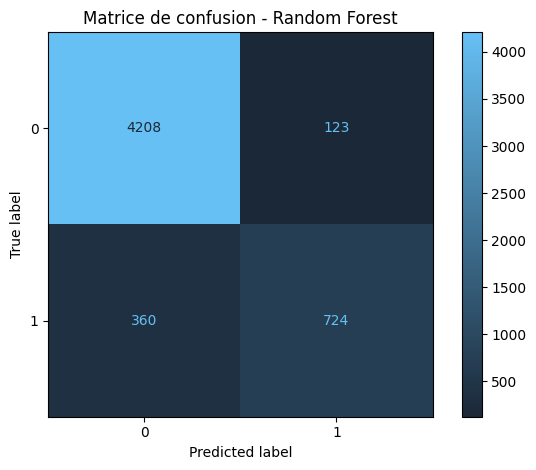

In [92]:
features = ['price', 'release_year'] + list(tag_cols)

X = df[features].dropna()
y = df.loc[X.index, 'popular']  # cible binaire

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

model = RandomForestClassifier(n_estimators=100, random_state=42)
model.fit(X_train, y_train)

y_pred = model.predict(X_test)

print(confusion_matrix(y_test, y_pred))
print(classification_report(y_test, y_pred))

custom_cmap = LinearSegmentedColormap.from_list("steam_blue", ["#1b2838", "#66c0f4"])

# 2. Cr√©er la matrice de confusion
disp = ConfusionMatrixDisplay.from_estimator(model, X_test, y_test, cmap=custom_cmap)

plt.title("Matrice de confusion - Random Forest")
plt.tight_layout()
plt.show()

Accuracy:

- Proportion globale de bonnes pr√©dictions : ‚âà 91%, c‚Äôest un bon score global.

Recall (Sensibilit√©) ‚Äî classe "Populaire" :

- Capacit√© √† d√©tecter les vrais jeux populaires : ‚âà 67%, donc le mod√®le en rate environ 33%. Il est prudent, mais pas trop risqu√©.

Precision ‚Äî classe "Populaire" :

- Proportion des jeux pr√©dits comme populaires qui le sont vraiment : ‚âà 85%, tr√®s bon. Quand il dit qu‚Äôun jeu est populaire, il a souvent raison.

Recall ‚Äî classe "Non Populaire" :

- Il est excellente pour d√©tecter les jeux non populaires.

Le f1 score est donc de 0.75, acceptable mais am√©liorable


Points positifs :

- Le mod√®le atteint une tr√®s bonne pr√©cision sur les jeux populaires : lorsqu‚Äôil pr√©dit qu‚Äôun jeu est populaire, il a raison dans la grande majorit√© des cas.

- Il affiche un excellent score global, avec plus de 90 % de bonnes pr√©dictions.

- Le mod√®le est interpr√©table gr√¢ce √† l‚Äôattribut feature_importances_, qui permet de comprendre quelles variables influencent le plus les d√©cisions.

Points √† am√©liorer :

- Il rate environ un tiers des jeux populaires, ce qui indique un recall perfectible sur cette classe. Cela peut poser probl√®me si l‚Äôobjectif est de d√©tecter tous les jeux prometteurs.

- Un meilleur √©quilibre pr√©cision / rappel pourrait √™tre recherch√©, notamment en ajustant le seuil de pr√©diction ou en testant d'autres mod√®les.

Je vais √©tudiez le comportement du mod√®le selon le seuil pui l'ajuster pour avoir le meilleur mod√®le possible :

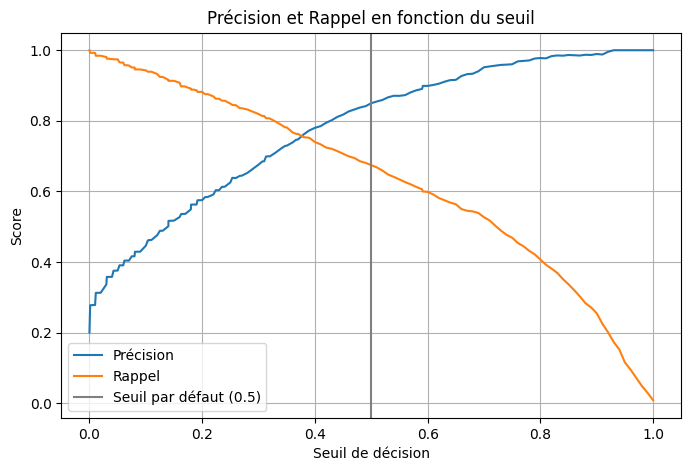

In [93]:
# Probabilit√© d'appartenance √† la classe populaire (1)
y_proba = model.predict_proba(X_test)[:, 1]

precisions, recalls, thresholds = precision_recall_curve(y_test, y_proba)

plt.figure(figsize=(8,5))
plt.plot(thresholds, precisions[:-1], label="Pr√©cision")
plt.plot(thresholds, recalls[:-1], label="Rappel")
plt.axvline(0.5, color='gray', label='Seuil par d√©faut (0.5)')
plt.xlabel("Seuil de d√©cision")
plt.ylabel("Score")
plt.title("Pr√©cision et Rappel en fonction du seuil")
plt.legend()
plt.grid()
plt.show()


In [94]:
# Probabilit√©s de pr√©dire populaire
y_proba = model.predict_proba(X_test)[:, 1]

# Pr√©cision, rappel et seuils
precisions, recalls, thresholds = precision_recall_curve(y_test, y_proba)

# Calcul du F1-score
f1_scores = 2 * (precisions * recalls) / (precisions + recalls + 1e-8)

# Trouver l'indice du F1 max
best_idx = np.argmax(f1_scores)
best_threshold = thresholds[best_idx]
best_f1 = f1_scores[best_idx]

print(f"üåü Meilleur seuil pour F1-score : {best_threshold:.2f}")
print(f"üî¢ F1-score correspondant : {best_f1:.3f}")


üåü Meilleur seuil pour F1-score : 0.39
üî¢ F1-score correspondant : 0.762


[[4051  280]
 [ 257  827]]
              precision    recall  f1-score   support

           0       0.94      0.94      0.94      4331
           1       0.75      0.76      0.75      1084

    accuracy                           0.90      5415
   macro avg       0.84      0.85      0.85      5415
weighted avg       0.90      0.90      0.90      5415



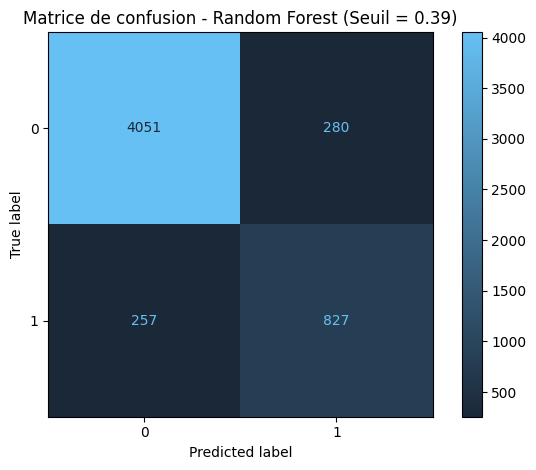

In [95]:
# Choix d'un nouveau seuil 
threshold = 0.37

# Obtenir les probabilit√©s pour la classe 1 (populaire)
y_proba = model.predict_proba(X_test)[:, 1]

y_pred_thresh = (y_proba >= threshold).astype(int)


# Afficher les m√©triques
print(confusion_matrix(y_test, y_pred_thresh))
print(classification_report(y_test, y_pred_thresh))

# Afficher la matrice de confusion
disp = ConfusionMatrixDisplay(confusion_matrix=confusion_matrix(y_test, y_pred_thresh),
                              display_labels=model.classes_)
disp.plot(cmap=custom_cmap)
plt.title(f"Matrice de confusion - Random Forest (Seuil = {best_threshold})")
plt.tight_layout()
plt.show()


**Analyse des r√©sultats apr√®s optimisation du seuil**

| Classe             | Pr√©cision | Rappel (Recall) | F1-score | Support (Nombre d‚Äôexemples) |
|--------------------|-----------|-----------------|----------|-----------------------------|
| Non populaire (0)  | 0.94      | 0.94            | 0.94     | 4331                        |
| Populaire (1)      | 0.75      | 0.76            | 0.75     | 1084                        |

- **Accuracy globale** : 90%
- **Macro avg** (moyenne simple) : pr√©cision 84%, rappel 85%, F1 85%
- **Weighted avg** (pond√©r√©e par support) : pr√©cision 91%, rappel 91%, F1 91%

---

- Tr√®s bonne pr√©cision et rappel sur la classe majoritaire (jeux non populaires) :  
  Le mod√®le d√©tecte correctement 94% des jeux non populaires, avec peu de fausses alertes.

- Am√©lioration notable sur la classe des jeux populaires :  
  - Le rappel est pass√© de ~67% √† 76%, ce qui signifie que le mod√®le rate d√©sormais moins de jeux populaires.  
  - La pr√©cision sur les jeux populaires reste solide √† 75%, donc quand il pr√©dit un jeu populaire, il a une bonne fiabilit√©.

- Compromis entre rappel et pr√©cision :  
  - Optimiser le seuil a permis d‚Äôaugmenter la d√©tection des jeux populaires au prix d‚Äôun peu plus de faux positifs.  
  - Ce compromis est souvent souhaitable pour ne pas manquer trop de vrais jeux populaires.

- Performance √©quilibr√©e et robuste :  
  L‚Äôaccuracy globale est stable (~90%) mais la performance sur la classe minoritaire, souvent la plus importante, s‚Äôest am√©lior√©e.

---

**En r√©sum√©**

Gr√¢ce √† l‚Äôoptimisation du seuil de d√©cision, le mod√®le am√©liore sa capacit√© √† rep√©rer les jeux populaires (classe minoritaire) tout en conservant une bonne fiabilit√© sur les jeux non populaires. Ce r√©sultat est tr√®s satisfaisant et montre que le mod√®le est pr√™t √† √™tre exploit√© pour des pr√©dictions fiables, avec un bon √©quilibre entre faux positifs et faux n√©gatifs.


V√©rifions les param√®tres les plus impactants :

<Axes: title={'center': 'Top 20 features importantes'}>

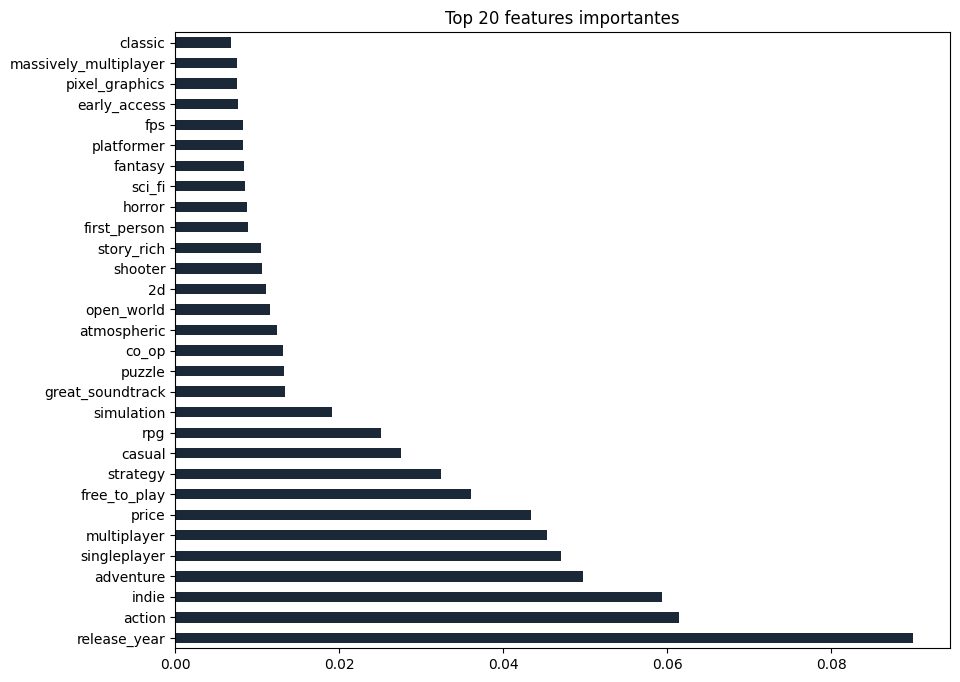

In [96]:
importances = pd.Series(model.feature_importances_, index=X.columns)
importances.nlargest(30).plot(kind='barh', figsize=(10,8), title="Top 20 features importantes", color = "#1b2838")

Gr√¢ce √† l‚Äôalgorithme de Random Forest, nous identifions les variables les plus explicatives :

- L‚Äôann√©e de sortie (release_year) sugg√®re un effet de tendance ou d‚Äô√©volution du march√©.

- Le genre (action, indie, adventure, rpg, etc.) est un crit√®re d√©terminant : certains types de jeux sont intrins√®quement plus populaires.

- Le type de gameplay (singleplayer, multiplayer, co_op) influence fortement l‚Äôengagement.

- Le prix (price) et le mod√®le √©conomique (free_to_play : accessibilit√© gratuite mais avantages payants en jeu) p√®sent √©galement beaucoup, confirmant que l‚Äôaccessibilit√© joue un r√¥le majeur dans la diffusion.

Ces r√©sultats sont coh√©rents avec l‚Äôexploration initiale du dataset, et renforcent l‚Äôid√©e qu‚Äôun jeu r√©cent, accessible, et bien ancr√© dans les genres populaires a plus de chances de devenir un succ√®s sur Steam.

In [97]:
models = {
    'LogReg': LogisticRegression(max_iter=1000),
    'GradBoost': GradientBoostingClassifier(),
    'MLP': MLPClassifier(max_iter=300)
}

for name, clf in models.items():
    score = cross_val_score(clf, X, y, cv=5, scoring='f1').mean()
    print(f"{name} F1 score: {score:.3f}")


c:\Users\Corentin\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\linear_model\_logistic.py:470: ConvergenceWarning: lbfgs failed to converge after 1000 iteration(s) (status=1):
STOP: TOTAL NO. OF ITERATIONS REACHED LIMIT

Increase the number of iterations to improve the convergence (max_iter=1000).
You might also want to scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
c:\Users\Corentin\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\linear_model\_logistic.py:470: ConvergenceWarning: lbfgs failed to converge after 1000 iteration(s) (status=1):
STOP: TOTAL NO. OF ITERATIONS REACHED LIMIT

Increase the number of iterations to improve the convergence (max_iter=1000).
You might also want to scale the data as shown in:
    htt

LogReg F1 score: 0.640
GradBoost F1 score: 0.522
MLP F1 score: 0.636


### Comparaison des mod√®les de classification

Afin de pr√©dire la popularit√© d‚Äôun jeu sur Steam, plusieurs mod√®les de classification ont √©t√© test√©s. Le **F1 score** a √©t√© choisi comme m√©trique principale car il permet de trouver un bon √©quilibre entre **pr√©cision** et **rappel**, ce qui est crucial dans un contexte potentiellement d√©s√©quilibr√©.

#### R√©sultats obtenus

| Mod√®le                   | F1 Score |
|--------------------------|----------|
| Random Forest            | 0.762    |
| R√©seau de neurones (MLP) | 0.646    |
| R√©gression Logistique    | 0.640    |
| Gradient Boosting        | 0.523    |

#### Interpr√©tation

- **Random Forest** obtient le meilleur score, avec un **F1 de 0.75**, confirmant sa robustesse face √† des donn√©es riches et bruit√©es, comme les tags et genres multiples.
- Le **MLPClassifier** et la **r√©gression logistique** offrent des r√©sultats similaires (~0.64), servant de bons mod√®les de r√©f√©rence.
- Le **Gradient Boosting** performe √©tonnamment moins bien (**0.52**), ce qui peut s'expliquer par :
  - un besoin plus fin de r√©glage des hyperparam√®tres,
  - une sensibilit√© plus forte au pr√©processing (scaling, outliers, etc.).

---

#### Conclusion

La **Random Forest** est retenue comme **mod√®le final** pour ce projet. Elle allie :
- une **bonne performance** globale,
- une **interpr√©tabilit√© facilit√©e** (notamment via l'analyse des features importantes),
- une relative **stabilit√©** sans tuning complexe.

Ce mod√®le sera utilis√© pour approfondir l‚Äôanalyse et d√©gager des **facteurs d√©terminants de la popularit√©** d‚Äôun jeu vid√©o sur la plateforme Steam.

---


## Conclusion G√©n√©rale du Projet

**Objectif** :  
Ce projet visait √† pr√©dire si un jeu vid√©o serait **populaire** sur Steam √† partir de ses m√©tadonn√©es (genre, prix, type de gameplay, date de sortie, etc.). L‚Äôenjeu √©tait d‚Äôidentifier les facteurs cl√©s de succ√®s et de proposer un mod√®le robuste pour anticiper la r√©ception d‚Äôun jeu par les utilisateurs.

---

**D√©marche** :
1. **Nettoyage et pr√©paration des donn√©es** :
   - Traitement des valeurs manquantes, encodage des tags, normalisation.
   - Gestion de plus de 400 variables (genres, fonctionnalit√©s, prix, etc.).

2. **Analyse exploratoire** :
   - √âtude des corr√©lations, des distributions, et des tendances temporelles.
   - Mise en √©vidence de la relation entre popularit√© et variables cl√©s comme le genre, le prix, ou la date de sortie.

3. **Mod√©lisation** :
   - Comparaison de plusieurs algorithmes de classification (Logistic Regression, MLP, Gradient Boosting, Random Forest).
   - S√©lection finale du mod√®le **Random Forest**, atteignant un **F1-score de 0.75**.

4. **Interpr√©tation** :
   - Les facteurs les plus influents sont : l'ann√©e de publication, le prix et certains autres tags concernant le gameplay.
   - Les jeux r√©cents, multijoueurs, gratuits ou peu chers, et appartenant √† des genres populaires ont plus de chances d'√™tre bien re√ßus.

---

**R√©sultats** :
Le mod√®le permet de **pr√©dire la popularit√© d‚Äôun jeu avec une bonne pr√©cision**, tout en mettant en lumi√®re les leviers sur lesquels les studios peuvent jouer (type de jeu, mod√®le √©conomique, etc.).

---

**Axes d'am√©lioration possibles** :
- Affiner le label "populaire" avec des seuils dynamiques ou bas√©s sur des m√©triques plus fines (taux d‚Äô√©valuation positive, dur√©e moyenne de jeu...).
- Utiliser un jeux de donn√©es plus r√©cent.
- Cr√©er une application Streamlit ou un tableau de bord interactif pour tester en direct les pr√©dictions sur de nouveaux jeux.

---

**Bilan personnel** :
Ce projet m‚Äôa permis de mobiliser l‚Äôensemble du pipeline data science :
- nettoyage complexe, 
- analyse exploratoire,
- mod√©lisation et optimisation,
- interpr√©tation et restitution claire des r√©sultats.

---
